In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno as msno
import matplotlib.pyplot as plt
from datetime import date
today = date.today()
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import sklearn
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
import string
from sklearn.model_selection import GridSearchCV
from itertools import combinations
from util import *

### Fonction de préprocessing
* RemoveStopWord : Supression des mots qui sont dans les Stop Word English
* Lemmatisation : Fonction qui trouve la racine des mots
* RemoveTop100 : Fonction qui supprime les mots qui ne sont pas dans le TOP 100 (Utilisé pour les Tags)

In [2]:
#Lecture du Fichier
df = pd.read_csv('QueryResults.csv', sep = ',', encoding='UTF-8')

#Lecture du Fichier de tags
#df_tags1 = pd.read_csv('Tags1.csv', sep = ',', encoding='UTF-8')
#df_tags2 = pd.read_csv('Tags2.csv', sep = ',', encoding='UTF-8')

#df_tags_full = pd.concat([df_tags1, df_tags2], axis=0)



In [ ]:
print(df.shape)
print(df.head(5))

In [ ]:
df.info()

In [ ]:
df.isna().mean()

In [ ]:
#Téléchargement des packages nltk
nltk.download()

## Mise en minuscule

In [3]:
df["BODY"] = df["BODY"].str.lower()
df["Tags"] = df["Tags"].str.lower()
df["Title"] = df["Title"].str.lower()

In [4]:
df["TitleBody"] = df["Title"] + " " + df["BODY"]

# Traitement du champs Tags
* On détermine les 100 Tags les plus utlisés
* On supprime tous les Tags qui ne font pas partis de ce TOP 100
* Supression des lignes Tags

## Première méthode avec le CountVectorizer (Sac de Mots)

In [ ]:
# Processing tags
df["Tags1"] = df["Tags"].replace({"<" : " "},
                                     regex=True)
df["Tags1"] = df["Tags1"].replace({">" : ","},
                                     regex=True)
df["Tags1"] = df["Tags1"].str.rstrip(',')

In [ ]:
vectorizer = CountVectorizer(max_features=100)
bow_tags = vectorizer.fit_transform(df["Tags1"]).toarray()
df_tags = pd.DataFrame(bow_tags, columns=vectorizer.get_feature_names_out())
df_tags = pd.DataFrame(df_tags.sum(), columns=["Value"])

In [ ]:
top_20_tags_word = df_tags.sort_values("Value", ascending=False)[:30]

plt.figure(figsize=(10,5))
plt.barh(y=top_20_tags_word.index, width=top_20_tags_word.Value)
plt.title("Histogramme des 20 tags les plus représentés (Bag-Of-Words)")
plt.show()

In [ ]:
tags_more_frequent = df_tags.loc[df_tags["Value"] >= 150].sort_values("Value", ascending=False).index.tolist()

In [ ]:
tags_only = df["Tags1"].str.split(",", expand=True)
df = pd.merge(df, tags_only,left_index=True,right_index=True)
df.columns = ["Id", "Title", "Body", "Tags","CreationDate","Tags1" ,"Tags_1", "Tags_2", "Tags_3", "Tags_4", "Tags_5"]

In [ ]:
tags = ["Tags_1", "Tags_2", "Tags_3", "Tags_4", "Tags_5"]

for i in tags_more_frequent:
    for j in tags:
        more_frequent = df.loc[df[j].str.contains(i, na=True)]
        
more_frequent.drop(["Tags_1", "Tags_2", "Tags_3", "Tags_4", "Tags_5"], axis=1, inplace=True)

## Deuxième méthode avec le TOKENIZER et l'expression régulière

In [5]:
#Expression régulière pour prendre uniquement les valeurs entre <>
tokenizer = RegexpTokenizer('(?<=\<).*?(?=\>)')

#Création de la colonne avec ces valeurs
df['tags_words'] = df.apply(lambda row: tokenizer.tokenize(row['Tags']), axis=1)

#Comptage de l'utlisation des mots
Top_Word = nltk.FreqDist()
Top100 = []
for x in df['tags_words']:
    Top_Word += nltk.FreqDist(x)

for i in Top_Word.most_common()[0:100]:
    Top100.append(i[0])
    
#Suppression des Tags qui ne sont pas dans le TOP
df['processed_tags_final'] = df.apply(lambda row:removeNotTop100(row['tags_words'],Top100), axis=1)

In [6]:
#Suppression des lignes sans Tags
df = df.dropna()

In [7]:
df.shape

(15171, 8)

## Affichage d'un WORDCLOUD sur la feature TAGS

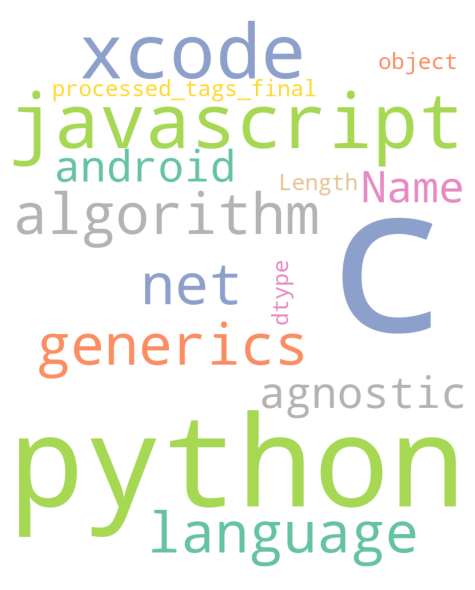

In [8]:
wordcloud = WordCloud(width = 800, height = 1000,
                max_words=1000,
                background_color ='white',
                min_font_size = 12,
                colormap="Set2").generate(str(df['processed_tags_final']))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# Préprocesing du champs BODY
* Utilisation de BEAUTIFULSOUP pour le traitement HTML
* Puis remplacement des retours chariots et des :
* Création du nuage de mots
* Supression des StopWord Anglais

In [9]:
#Préprocessing du champ BODY
df['processed_body'] = df['BODY'].map(lambda x: BeautifulSoup(x, "html.parser").get_text())
df['processed_body'] = df['processed_body'].map(lambda x: x.replace('\n', ' '))
df['processed_body'] = df['processed_body'].map(lambda x: x.replace(':', ''))

punct = string.punctuation
for c in punct:
    if c != '#':
        df['processed_body'] = df['processed_body'].map(lambda x: x.replace(c, ''))

#Création des nuages de mots avec NLTK
df['processed_body2'] = df.apply(lambda row: nltk.word_tokenize(row['processed_body'],language='english'), axis=1)

#Supression des StopWord
df['processed_body_final'] = df.apply(lambda row:removeStopWord(row['processed_body2']), axis=1)

#Lemmatisation
#df['processed_body_final'] = df.apply(lambda row:lemmatisation(row['processed_body_final']), axis=1)

### Création d'un nuage de mots pour le BODY

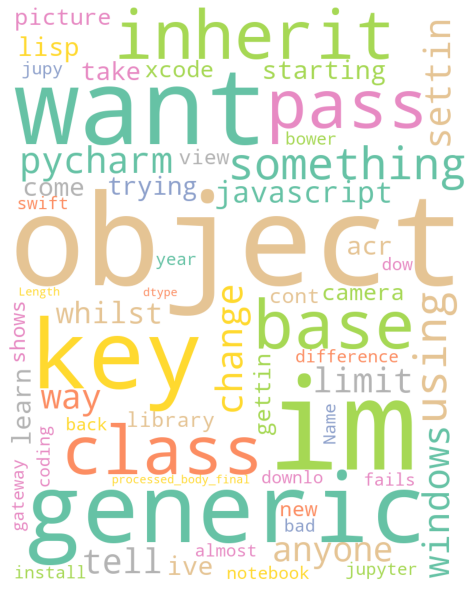

In [10]:
wordcloud = WordCloud(width = 800, height = 1000,
                max_words=1000,
                background_color ='white',
                min_font_size = 12,
                colormap="Set2").generate(str(df['processed_body_final']))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# Préprocesing du champs Titre

* Remplacement des retours chariots et des :
* Création du nuage de mots
* Supression des StopWord Anglais

In [11]:
#Préprocessing du champ Title
df['processed_title'] = df['Title'].map(lambda x: x.replace('\n', ' '))

punct = string.punctuation
for c in punct:
    if c != '#':
        df['processed_title'] = df['processed_title'].map(lambda x: x.replace(c, ''))

df['processed_title'] = df['processed_title'].map(lambda x: x.replace(':', ''))

#Création des nuages de mots avec NLTK
df['processed_title2'] = df.apply(lambda row: nltk.word_tokenize(row['processed_title']), axis=1)

#Supression des StopWord
df['processed_title_final'] = df.apply(lambda row:removeStopWord(row['processed_title2']), axis=1)

#Lemmatisation
#df['processed_title_final'] = df.apply(lambda row:lemmatisation(row['processed_title_final']), axis=1)

#Traitement du C#
df['processed_title_final'] = df.apply(lambda row:processCSharp(row['processed_title_final']), axis=1)

In [12]:
#Suppression des colonnes inutiles
df.drop({'processed_body','processed_body2','tags_words','processed_title','processed_title2'}, axis=1, inplace=True)

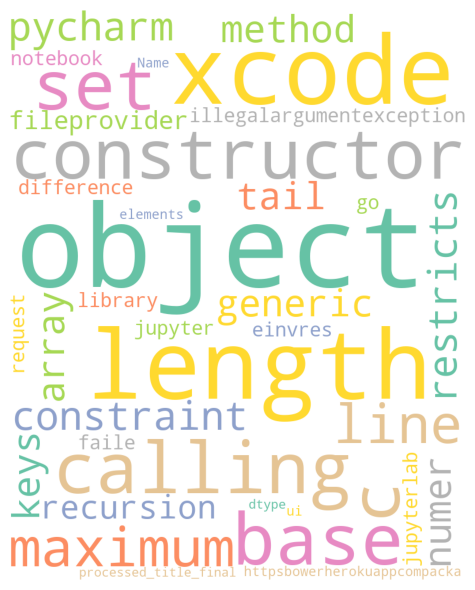

In [13]:
wordcloud = WordCloud(width = 800, height = 1000,
                max_words=1000,
                background_color ='white',
                min_font_size = 12,
                colormap="Set2").generate(str(df['processed_title_final']))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [ ]:
df.head(10)

In [ ]:
#Serialisation de mon Dataframe pour l'utiliser côté modelisation.
import pickle
pickle.dump(df, open('df_afterPreprocessing.pickle', 'wb')) #Saving DF